In [111]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
docs = ['this is a test ', 'this is also a test', 'why and I still testing this', 'ok now the test is over']


class SkipGram:
    def __init__(self, max_len=5, tokenizer=None):
        self.max_len = max_len
        self.input_len = 2
        self.tokenizer = tokenizer
        self.words = None
        self.probs = None
        self.n_words = None
        if tokenizer:
            self._setup_words()
        pass

    def _setup_words(self):
        self.n_words = sum(self.tokenizer.word_counts.values())
        self.words = np.array(list(self.tokenizer.word_counts.keys()))
        self.probs = np.array(list(self.tokenizer.word_counts.values()))/self.n_words

    def fit(self, docs):
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(docs)
        self._setup_words()

    def _text_to_padded_sequences(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len, padding='post', truncating='post')
        return seqs_padded
    def text_to_seq(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len-1, padding='post', truncating='post')
        return seqs_padded
    def _random_choice_int(self, v):
        new_word = np.random.choice(self.words, 1, p=self.probs)[0]
        output = self.tokenizer.word_index[new_word]
        if v == output:
            new_word = np.random.choice(self.words, 1, p=self.probs)[0]
            output = self.tokenizer.word_index[new_word]
        
        return output

    def _missing_word_gen(self, docs):
        seqs = self._text_to_padded_sequences(docs)
        for seq in seqs:
            seq = np.array(seq)
            if sum(seq) != 0:
                for i in range(self.input_len, self.max_len):
                    new_seq = np.delete(seq, i)
                    x = np.array([new_seq, new_seq])
                    word_index = seq[i]
                    new_word_index = self._random_choice_int(word_index)
                    context = np.array([[word_index], [new_word_index]])
                    label = np.array([[1], [0]])
                    yield x, context, label

    def array_to_texts(self, x):
        return list(s.tokenizer.sequences_to_texts_generator(x))

    def transform(self, docs):
        array_list = list(self._missing_word_gen(docs))
        x = np.vstack([v[0] for v in array_list])
        context = np.vstack([v[1] for v in array_list])
        labels = np.vstack([v[2] for v in array_list]).flatten()
        return x, context, labels

docs = ['this is a test', 'this is still a test', 'why am I still testing', '']
s = SkipGram()
s.fit(docs)
x, context, labels = s.transform(docs)
list(zip(s.array_to_texts(x), s.array_to_texts(context), labels ))

[('this is test', 'a', 1),
 ('this is test', 'am', 0),
 ('this is a', 'test', 1),
 ('this is a', 'is', 0),
 ('this is a test', '', 1),
 ('this is a test', 'is', 0),
 ('this is a test', 'still', 1),
 ('this is a test', 'is', 0),
 ('this is still test', 'a', 1),
 ('this is still test', 'is', 0),
 ('this is still a', 'test', 1),
 ('this is still a', 'still', 0),
 ('why am still testing', 'i', 1),
 ('why am still testing', 'testing', 0),
 ('why am i testing', 'still', 1),
 ('why am i testing', 'is', 0),
 ('why am i still', 'testing', 1),
 ('why am i still', 'this', 0)]

In [112]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/kamillamagna/ICD-10-CSV/master/codes.csv', header=None)
df.head()
docs = df.iloc[:, 4]

df.head()

,0,1,2,3,4,5
0,A00,0,A000,"Cholera due to Vibrio cholerae 01, biovar chol...","Cholera due to Vibrio cholerae 01, biovar chol...",Cholera
1,A00,1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor","Cholera due to Vibrio cholerae 01, biovar eltor",Cholera
2,A00,9,A009,"Cholera, unspecified","Cholera, unspecified",Cholera
3,A010,0,A0100,"Typhoid fever, unspecified","Typhoid fever, unspecified",Typhoid fever
4,A010,1,A0101,Typhoid meningitis,Typhoid meningitis,Typhoid fever


In [113]:
max_len = 6
s = SkipGram(max_len=max_len)
s.fit(docs)
x, context, labels = s.transform(docs)

In [114]:
list(zip(s.array_to_texts(x[0:10,:]), s.array_to_texts(context[0:10,:]), labels[0:10] ))

[('cholera due vibrio cholerae 01', 'to', 1),
 ('cholera due vibrio cholerae 01', 'ulna', 0),
 ('cholera due to cholerae 01', 'vibrio', 1),
 ('cholera due to cholerae 01', 'ankle', 0),
 ('cholera due to vibrio 01', 'cholerae', 1),
 ('cholera due to vibrio 01', 'accident', 0),
 ('cholera due to vibrio cholerae', '01', 1),
 ('cholera due to vibrio cholerae', 'subsequent', 0),
 ('cholera due vibrio cholerae 01', 'to', 1),
 ('cholera due vibrio cholerae 01', 'region', 0)]

In [115]:
x.shape, context.shape, labels.shape

((573632, 5), (573632, 1), (573632,))

In [116]:
len(s.tokenizer.word_index)


7122

In [123]:

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Flatten, Dense, BatchNormalization
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.callbacks import EarlyStopping
esm =  EarlyStopping(patience=2)
input_len = x.shape[1]
vocab_size = len(s.tokenizer.word_index) + 1

dim_embedddings =50

# inputs
w_inputs = Input(shape=(input_len, ), dtype='int32')
w = Embedding(vocab_size, dim_embedddings,name= 'embx')(w_inputs)

# context
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(vocab_size, dim_embedddings, name= 'embc')(c_inputs)
o = Dot(axes=2)([w, c])
o = BatchNormalization()(o)
o = Reshape((1,input_len), input_shape=(input_len, 1))(o)
o = Flatten(name='flatten')(o)
o = Dense(1)(o)
o = Activation('sigmoid')(o)

model = Model(inputs=[w_inputs, c_inputs], outputs=o)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
# fit the model


Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embx (Embedding)                (None, 5, 50)        356150      input_43[0][0]                   
__________________________________________________________________________________________________
embc (Embedding)                (None, 1, 50)        356150      input_44[0][0]                   
___________________________________________________________________________________________

In [130]:
model.fit([x, context], labels, batch_size=256, epochs=5, callbacks=[esm ])

Epoch 1/5
573632/573632 [==============================] - 15s 26us/step - loss: 0.0397
Epoch 2/5
  6144/573632 [..............................] - ETA: 17s - loss: 0.0301

/home/matthew/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


573632/573632 [==============================] - 15s 26us/step - loss: 0.0393
Epoch 3/5
573632/573632 [==============================] - 15s 26us/step - loss: 0.0391
Epoch 4/5
573632/573632 [==============================] - 15s 26us/step - loss: 0.0389
Epoch 5/5
573632/573632 [==============================] - 16s 28us/step - loss: 0.0386


In [131]:
emb_input = Input(shape=(input_len, ), dtype='int32')
emb_layer = model.get_layer('embx')(emb_input )
emb_model = Model(inputs=emb_input, outputs=emb_layer)

seqs = s.text_to_seq(docs)
seqs[1:10]

array([[3755,   55,   21, 3128, 3756],
       [3755,    4,    0,    0,    0],
       [2675,  880,    4,    0,    0],
       [2675, 1054,    0,    0,    0],
       [2675,  880,    6,  308,  473],
       [2675,  782,    0,    0,    0],
       [2675,  211,    0,    0,    0],
       [2675,  396,    0,    0,    0],
       [2675,  880,    6,    8,  286]], dtype=int32)

In [132]:
vects = emb_model.predict(seqs)
vects.shape

(71704, 5, 50)

In [133]:
vecs_reshape = np.reshape(vects, (vects.shape[0], -1))
vecs_reshape.shape

(71704, 250)

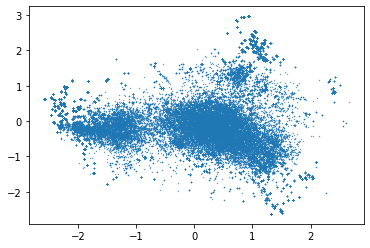

In [134]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
p = PCA(2).fit(vecs_reshape)
comps = p.transform(vecs_reshape)
xx = comps[:, 0]
yy = comps[:, 1]
plt.scatter(xx, yy,s=.1)
plt.show()